<h1 style="color: rgb(0, 0, 119);font-size: 7rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;text-align: center;">La detection d'autisme chez les enfants avec -CNN-</h1>
<br><br><br><br>

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> Importer les modules :</h1>

In [45]:
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf    
from sklearn import metrics
from tqdm import tqdm
import pickle

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> Importer et stocker les images :</h1>

In [2]:
class_names = ['Non_Autistic', 'Autistic']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMAGE_SIZE = (200, 200)

In [3]:
def load_data():

    datasets = ['Autisme-Dataset-CNN/train', 'Autisme-Dataset-CNN/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C://Users/HP/BDM/data/train


100%|██████████████████████████████████████████████████████████████| 1327/1327 [00:04<00:00, 289.63it/s]


Loading C://Users/HP/BDM/data/test


100%|████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 282.34it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 2654
Number of testing examples: 280
Each image is of size: (200, 200)


# Statistiques :

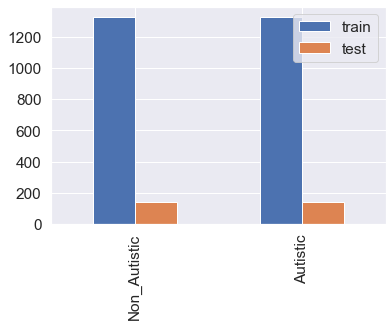

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

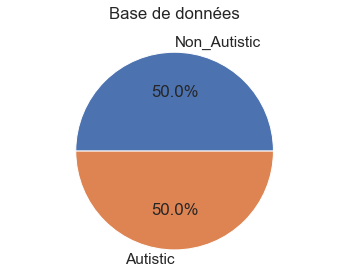

In [8]:
plt.pie(train_counts,
        explode=(0, 0,) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Base de données\n')
plt.show()

# Normalisation des images :

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Affichage des exemples :

In [10]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

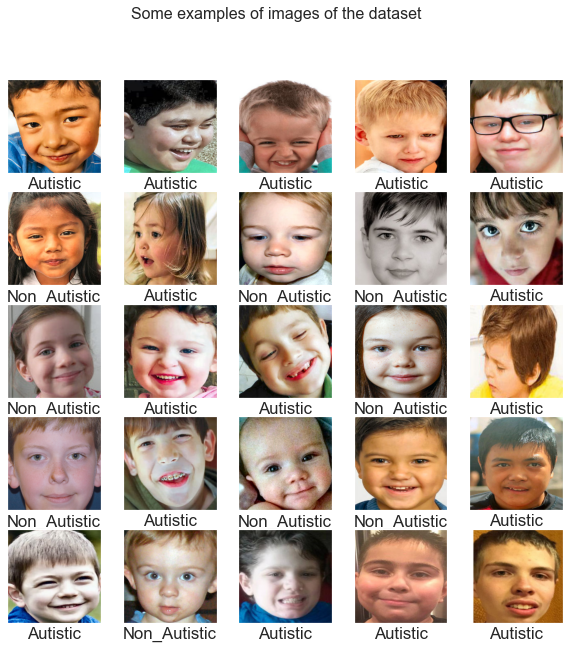

In [11]:
display_examples(class_names, train_images, train_labels)

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> Entrainer du modèle :</h1>

# Déclaration :

In [25]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
tf.keras.layers.Dense(1, activation='sigmoid')])

# Compilation et optimisation :

In [26]:
model.compile(loss='binary_crossentropy',
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
metrics='accuracy')

# Entraînement

In [33]:
history = model.fit(train_images, train_labels,steps_per_epoch=8,epochs=10,verbose=1,validation_data=(test_images, test_labels),validation_steps=8)

Epoch 1/10
8/8 [==============================] - 20s 2s/step - loss: 0.2590 - accuracy: 0.8971 - val_loss: 0.3219 - val_accuracy: 0.8607
Epoch 2/10
8/8 [==============================] - 19s 2s/step - loss: 0.2516 - accuracy: 0.8937 - val_loss: 0.3788 - val_accuracy: 0.8179
Epoch 3/10
8/8 [==============================] - 16s 2s/step - loss: 0.2503 - accuracy: 0.8896 - val_loss: 0.3945 - val_accuracy: 0.8214
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 0.2196 - accuracy: 0.9107 - val_loss: 0.4047 - val_accuracy: 0.8179
Epoch 5/10
8/8 [==============================] - 15s 2s/step - loss: 0.1922 - accuracy: 0.9258 - val_loss: 0.5083 - val_accuracy: 0.8143
Epoch 6/10
8/8 [==============================] - 14s 2s/step - loss: 0.2154 - accuracy: 0.9126 - val_loss: 0.4107 - val_accuracy: 0.8250
Epoch 7/10
8/8 [==============================] - 14s 2s/step - loss: 0.2434 - accuracy: 0.8990 - val_loss: 0.4760 - val_accuracy: 0.7929
Epoch 8/10
8/8 [==================

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> Tester le modèle :</h1>


9/9 - 0s - loss: 0.3941 - accuracy: 0.8286


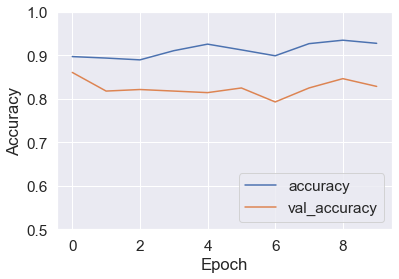

In [34]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [35]:
preds = model.predict(test_images,verbose=1)

9/9 [==============================] - 0s 46ms/step


In [36]:
print(test_images.shape)

(280, 200, 200, 3)


In [38]:
predicted = np.round(preds).reshape(280)
report = classification_report(test_labels, predicted,target_names=class_names)
print(report)

              precision    recall  f1-score   support

Non_Autistic       0.76      0.96      0.85       140
    Autistic       0.94      0.70      0.80       140

    accuracy                           0.83       280
   macro avg       0.85      0.83      0.83       280
weighted avg       0.85      0.83      0.83       280



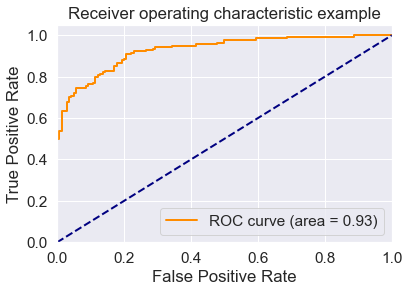

In [39]:
fpr, tpr, _ = roc_curve(test_labels, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [40]:
image = cv2.imread("001.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, IMAGE_SIZE)
image = image.reshape((1,200,200,3))

In [41]:
predict = model.predict(image)
print(predict[0][0])

1/1 [==============================] - 0s 227ms/step
0.0


In [43]:
if predict[0][0] >= 0.5:
    result = 'Autistic'
    print(result)
else:
    result = 'Non_Autistic'
    print(result)

Non_Autistic


In [48]:
model.save('my_model.h5')